In [378]:
import numpy as np
import math
from matplotlib import pyplot as plt
import cv2

In [3]:
world = np.zeros((12,12))

world

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [407]:
# constants
GOAL_GAIN = 5.5
OBSTACLE_GAIN = 1000
OBSTACLE_INFLUENCE = 5 # 5 cells of influence
OBSTACLE_LOCATION = [5.5, 5.5] 
# obstacle will occupy (5,5) (5,6), (6,5) (6,6)

# each square in gris is 0.25m x 0.25m
# grid side length is 3m
CELL_WIDTH = 0.25 
CELL_HEIGHT = 0.25

In [408]:
def compute_distance(cell1, cell2):
    i1, j1 = cell1
    i2, j2 = cell2
    return np.sqrt((j2 - j1)**2 + (i2-i1)**2)

In [409]:
# compute attractive potential for each matrix cell

# assume goal is at i,j = (0, 0)
U_att = np.zeros(world.shape)
for i in range(world.shape[0]):
    for j in range(world.shape[1]):
        rho = compute_distance([0, 0], [i, j])
        U_att[i][j] = 0.5 * GOAL_GAIN * (rho**2)

In [410]:
# compute repulsive force -- circular repulsive not working

U_rep = np.zeros(world.shape)
for i in range(world.shape[0]):
    for j in range(world.shape[1]):
        d = compute_distance(OBSTACLE_LOCATION, [i, j])
        
        if d <= OBSTACLE_INFLUENCE:
            U_rep[i][j] = 0.5 * OBSTACLE_GAIN + (1/d - 1/OBSTACLE_INFLUENCE)
        else:
            U_rep[i][j] = 0

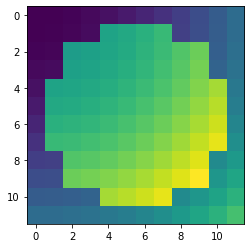

In [411]:
U = U_att + U_rep

plt.imshow(U)

In [412]:
def get_neighbors(cell, mapp):
    i, j = cell
    potential_neighbors = [
        [i+1, j+1],
        [i-1, j-1],
        [i+1, j-1],
        [i-1, j+1],
        [i-1, j],
        [i+1, j],
        [i, j-1],
        [i, j+1]
    ]
    valids = []
    for ne in potential_neighbors:
        if ne[0] >= 0 and ne[0] < mapp.shape[0] and ne[1] >= 0 and ne[1] < mapp.shape[1]:
            valids.append(ne)
    return valids

In [413]:
def gradient_descent(start, goal, field):
    cur = start
    stuck = False
    path = [start]
    count = 0
    mod_field = field.copy()
    while not stuck and cur != goal:
        print(cur)
        nes = get_neighbors(cur, mod_field)
        if len(nes) == 0:
            print("No neighbors")
            return path
        if len(nes) == 1:
            ne = nes[0]
            if mod_field[ne[0]][ne[1]] < mod_field[cur[0]][cur[1]]:
                cur = ne
                path.append(cur)
            else:
                stuck = True
                print("Local minima")
        else:
            ne = nes[0]
            best_grad = mod_field[ne[0]][ne[1]] - mod_field[cur[0]][cur[1]]
            best_ne = ne
            for i in range(1, len(nes)):
                ne = nes[i]
                grad = mod_field[ne[0]][ne[1]] - mod_field[cur[0]][cur[1]]
                if grad < best_grad:
                    best_grad = grad
                    best_ne = ne
            if best_grad >= 0:
                stuck = True
                print("Local minima")
            else:
                cur = best_ne
                path.append(cur)
        if stuck and count == 0:
            stuck = False
            count += 1
            mod_field[cur[0]][cur[1]] += 200
            print("adding noise")
        else:
            count = 0
    return path, stuck

In [422]:
path, stuck = gradient_descent([11, 11], [0, 0], U)
if stuck:
    print("Could not find path")
else:
    path = np.array(path)

[11, 11]
[10, 10]
[9, 10]
[8, 10]
Local minima
adding noise
[8, 10]
[7, 11]
[6, 11]
[5, 11]
[4, 11]
[3, 10]
[2, 10]
[1, 9]
[0, 8]
[0, 7]
[0, 6]
[0, 5]
[0, 4]
[0, 3]
[0, 2]
[0, 1]


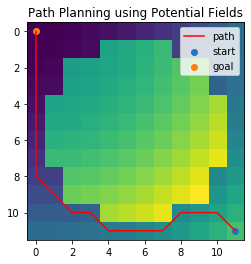

In [472]:
plt.imshow(U)
plt.scatter([11], [11], label='start')
plt.scatter([0], [0], label='goal')
plt.plot(path[:, 0], path[:, 1], 'r', label='path')
plt.title("Path Planning using Potential Fields")
plt.legend()

In [426]:
ROBOT_WIDTH = 0.25
ROBOT_HEIGHT = 0.25
def coordinate_to_waypoints(coords):
    """
    turns matrix i=y, j=x values into robot waypoints
    """
    # world is 12 x 12
    waypoints = []
    for elem in coords:
        # x is correct, but y is positive in opposite direction
        w_x, w_y = elem
        w_y = world.shape[0] - 1 - w_y
        waypoint_x = w_x*(ROBOT_WIDTH) + (ROBOT_WIDTH/2)
        waypoint_y = w_y *(ROBOT_HEIGHT) + (ROBOT_HEIGHT/2)
        waypoints.append([waypoint_x, waypoint_y])
    return waypoints

In [460]:
waypoints = np.array(coordinate_to_waypoints(path))

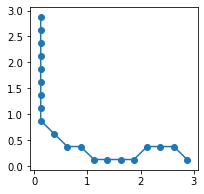

In [461]:
plt.figure(figsize=(3, 3))
plt.plot(waypoints[:, 0], waypoints[:, 1])
plt.scatter(waypoints[:, 0], waypoints[:, 1])

In [462]:
def compress_waypoints(wayps):
    """
    turns sequence of waypoints into smaller list
    by considering continuity in slope
    """
    denom = (wayps[1][0] - wayps[0][0])
    if denom == 0:
        prev_slope = np.inf
    else:
        prev_slope = (wayps[1][1] - wayps[0][1]) / denom
    condensed = [wayps[0]]
    
    for k in range(1, len(wayps)-1):
        wp = wayps[k]
        denom = (wayps[k+1][0] - wp[0])
        if denom == 0:
            slope_with_next = np.inf
        else:
            slope_with_next = (wayps[k+1][1] - wp[1]) / denom
        
        if slope_with_next != prev_slope:
            condensed.append(wp)
        prev_slope = slope_with_next
    condensed.append(wayps[-1])
    return np.array(condensed)

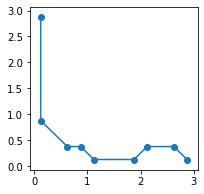

In [463]:
condensed_wps = compress_waypoints(waypoints)

plt.figure(figsize=(3,3))
plt.plot(condensed_wps[:, 0], condensed_wps[:, 1])
plt.scatter(condensed_wps[:, 0], condensed_wps[:, 1])

In [464]:
# add theta dimension to waypoints
condensed_wps = np.hstack([condensed_wps, np.zeros((condensed_wps.shape[0], 1))])
condensed_wps

array([[2.875, 0.125, 0.   ],
       [2.625, 0.375, 0.   ],
       [2.125, 0.375, 0.   ],
       [1.875, 0.125, 0.   ],
       [1.125, 0.125, 0.   ],
       [0.875, 0.375, 0.   ],
       [0.625, 0.375, 0.   ],
       [0.125, 0.875, 0.   ],
       [0.125, 2.875, 0.   ]])

In [465]:
def theta_to_next(wps):
    """
    returns theta for each waypoint which will point to
    the next waypoint
    """
    thetas = []
    for k in range(len(wps)-1):
        dy = wps[k+1][1] - wps[k][1]
        dx = wps[k+1][0] - wps[k][0]
        theta = math.atan2(dy, dx)
        thetas.append(theta)
    return np.array(thetas)

In [466]:
# modify theta dimensions for smoother motion 
final_wps = condensed_wps.copy()
final_wps[:-1, 2] = theta_to_next(final_wps[:])

In [467]:
 # no change in theta for last waypoint necessary
final_wps[-1, 2] = final_wps[-2, 2]

In [468]:
final_wps

array([[ 2.875     ,  0.125     ,  2.35619449],
       [ 2.625     ,  0.375     ,  3.14159265],
       [ 2.125     ,  0.375     , -2.35619449],
       [ 1.875     ,  0.125     ,  3.14159265],
       [ 1.125     ,  0.125     ,  2.35619449],
       [ 0.875     ,  0.375     ,  3.14159265],
       [ 0.625     ,  0.375     ,  2.35619449],
       [ 0.125     ,  0.875     ,  1.57079633],
       [ 0.125     ,  2.875     ,  1.57079633]])

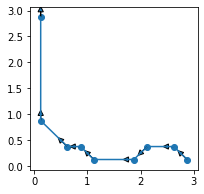

In [469]:
plt.figure(figsize=(3, 3))
axes = plt.axes()
plt.plot(final_wps[:, 0], final_wps[:, 1])
plt.scatter(final_wps[:, 0], final_wps[:, 1])
for k in range(len(final_wps)):
#     if k == 0:
    x, y, theta = final_wps[k]
    theta = (theta + 2*np.pi) % (2*np.pi)
    y_x = np.tan(theta)
    if theta == np.pi/2:
        d_x = 0.0001
        d_y = 0.1
    elif theta == 3*np.pi/2:
        d_x = 0.0001
        d_y = -0.1
    elif theta == np.pi:
        d_x = -0.1
        d_y = 0.0001
    elif theta == 2*np.pi:
        d_x = 0.1
        d_y = 0.0001
    elif theta < np.pi/2:
        d_x = 0.1 # q1
        d_y = y_x * d_x
    elif theta > np.pi/2 and theta < np.pi:
        # q2
        d_x = -0.1
        d_y = y_x * d_x
    elif theta > np.pi and theta < 3*np.pi/2:
        d_x = -0.1 # q3
        d_y = y_x * d_x
    else:
        d_x = 0.1
        d_y = y_x * d_x

    plt.arrow(x, y, d_x, d_y, head_width=0.1, head_length = 0.1)